# Problems in the Bicincitta data set from 2013

There are problems with the Bicincitta data that we need to address before loading the data into a reliable and proper data-base. We will point out these problems using examples, and measure their magnitude using systematic analysis, and then speculate about the cause behind these problems.


## Data
We load the data from JSONs provided to us by Bicincitta at the end of April 2015. 


In [142]:
import os
import json
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from string import *
plt.style.use('ggplot')
%matplotlib inline
import numpy as np

#because the strings in the jsons are web-quoted we will need to unquote them
import urllib

bikedatapath = os.path.join("../Bicincitta_Drop", "datasets_2013")
stnfile = file(os.path.join(bikedatapath, "stations.json"), "r")
subnetfile =  file(os.path.join(bikedatapath, "subnetworks.json"), "r")             
userfile =  file(os.path.join(bikedatapath, "users.json"), "r")                       
trxnfile =  file(os.path.join(bikedatapath, "transactions.json"), "r")                       

subnets = json.load(subnetfile)[u'RECORDS']
subnetfile.close()
stations = json.load(stnfile)[u'RECORDS']
stnfile.close()
users = json.load(userfile)[u'RECORDS']
userfile.close()
trxns = json.load(trxnfile)[u'RECORDS']
trxnfile.close()

The resulting data is in the form of lists of dictionaries. 

In [2]:
print "a subnetwork is described by, "
for k in subnets[0].keys():
    print "\t", k
print "\n a station is described by," 
for k in stations[0].keys():
    print "\t", k
    
print "\n a user is described by "
for k in users[0].keys():
    print "\t", k
    
print "\n a transaction is described by, " 
for k in trxns[0].keys():
    print "\t", k

a subnetwork is described by, 
	id
	name

 a station is described by,
	latitude
	name
	id
	longitude
	subnetwork_id

 a user is described by 
	subnetwork_id
	gender
	expires
	postal_code
	address
	id

 a transaction is described by, 
	direction
	user_id
	event_time
	created_at
	updated_at
	station_id
	id


The resulting dictionaries have ids that are UTF-8 strings. We change these to integers to make our work easier.  The addersses in the user data are web-quotes, which we need to *unquote*. We will also unquote the station names, just to be safe.  There are keys in a transaction that do not seem to correspond to the data, but refer to the time at which the data was loaded into the JSON provided to us.We will drop these variables, and change the *event_time* to a time object. 

In [128]:
for sn in subnets:
    sn['id'] = int(sn['id'])
    
for st in stations:
    st['id'] = int(st['id'])
    st['subnetwork_id'] = int(st['subnetwork_id'])
    st['name'] = urllib.unquote_plus(st['name'])    
    
for u in users:
    u['subnetwork_id'] = int(u['subnetwork_id'])
    u['id'] = int(u['id'])
    u['address'] = urllib.unquote_plus(u[u'address'])
    
for t in trxns:
    t['id'] = int(t['id'])
    t['station_id'] = int(t['station_id'])
    t['user_id'] = int(t['user_id'])
    


In [129]:
from datetime import datetime

trxns = [ {u'direction': t[u'direction'],
           u'user_id': t[u'user_id'],
           u'event_time': datetime.strptime(t[u'event_time'],
                                            "%m/%d/%Y %H:%M:%S"),
           u'station_id': t[u'station_id'],
           u'id': t[u'id']}
         for t in trxns]

trxns = sorted(trxns, key = lambda t: t[u'event_time'])

In [13]:
#We also sort the subnetworks and stations by their *id*.
subnets = sorted(subnets, key = lambda s: s[u'id'])
stations = sorted(stations, key = lambda s:s[u'id'])

In [130]:
#Stations and users have been assigned a *subnetwork_id* in the data. 
#We can add the subnetwork name to these data,

for s in stations:
    s[u'subnetwork_name'] = subnets[s['subnetwork_id'] - 1][u'name']

for u in users:
    i = u['subnetwork_id'] - 1
    if i < len(subnets):
        u[u'subnetwork_name'] = subnets[i][u'name']
    else:
        u[u'subnetwork_name'] = u'unknown'

In [135]:
subnets_db = pd.DataFrame(subnets)
subnets_db.sort( ['id'])

,id,name
0,1,La Cote
11,2,Agglo Fribourg
1,3,Bulle
2,4,Les Lacs-Romont
3,5,Bâle
15,6,Chablais
14,7,Valais Central
12,8,Yverdon-les-Bains
16,9,Lausanne-Morges
5,10,Campus


##Who are the users?

The simplest question may be the fraction of females vs males,

In [15]:
numFemales = 1.*sum(u['gender'] == "F" for u in users)
numMales = 1.*sum(u['gender'] == "M" for u in users)

print "Of all the users ", int(100*numFemales/len(users)), " percent are female ", \
"and ", int(100*numMales/len(users)), " percent males."

Of all the users  60  percent are female  and  39  percent males.


It would be interesting if 60% of the users were in fact female. However, as we will see later there seems to be a problem of user duplicacy biased towards females. 

## Subnetworks for stations users, and transactions

We have a data table for subnetworks, which contains the subnetwork's id and name. Both users and stations have been assigned a *subnetwork_id* which should be an integer pointing to the *id* variable in the subnetwork table.  We would expect all the subnetworks in this table to be conceptually equivalent.  Thus the subnetworks *PubliBike* and *Campus* should refer to the same concept of a subnetwork. However a peek at the data hints against this assumption. **It seems that there are two distinct concepts of a subnetwork in the subnetwork table.** There are several lines of evidence leading us to this conclusion.

First of all, only 11 of the 18 subnetworks have a station assigned to them, and 7 have no stations (see table in the appendix).

In [16]:
stn_sns = set( [s[u'subnetwork_id'] for s in stations] )
subnetsWithStns = [ s for s in subnets if s[u'id'] in stn_sns]
#print "Subnetworks that have stations assigned to them"
#pd.DataFrame(subnetsWithStns)

In [17]:
subnetsWithoutStns = [ s for s in subnets if s[u'id'] not in stn_sns]
#print "Subnetworks without any assigned stations"
#pd.DataFrame(subnetsWithoutStns)

While none of the stations have been assigned the subnetwork, most of the users are in subnetwork PubliBike,

In [18]:
users_pub = [u for u in users if u[u'subnetwork_id'] == 13]
print "Number of users from subnetwork PubliBike is", len(users_pub)

Number of users from subnetwork PubliBike is 58927


The subnetworks thus appear to mean two different things: 

1. a geographic subnetwork that has stations

2. an administrative subnetwork that is assigned to a user when she signs up.

In [19]:
user_sns = set(u['subnetwork_id'] for u in users)

users_d = { u[u'id']: u for u in users}

subnetsWithUsers = [ s for s in subnets if s[u'id'] in user_sns]

#print "subnetworks assigned to users"
#pd.DataFrame(subnetsWithUsers)

In [20]:
#print "subnets without any users"
subnetsWithoutUsers = [ s for s in subnets if s[u'id'] not in user_sns]
#pd.DataFrame(subnetsWithoutUsers)

In [21]:
#print "subnets with stations as well as users"
subnetsValid = [s for s in subnets if s[u'id'] in user_sns and s[u'id'] in stn_sns]
#pd.DataFrame(subnetsValid)

In [22]:
#As a summary, let us tabulate the fraction of users in each of the subnets,

all_sns = list(set(s['id'] for s in subnets).union(set(u['subnetwork_id'] for u in users)))
all_sns_names = {i: subnets[i - 1][u'name'] if i <= len(subnets) 
                                             else 'unknown'
                  for  i in all_sns}
subnet_numUsers = [{u'id': i,
                    u'name': all_sns_names[i],
                    u'numUsers': user_sns_list.count(i)}
                   for i in all_sns]
subnet_numUsers = sorted(subnet_numUsers, key=lambda s: s[u'numUsers'] )

#pd.DataFrame(subnet_numUsers)

NameError: name 'user_sns_list' is not defined

In [ ]:
sn_nu = pd.DataFrame(subnet_numUsers)[  ['name', 'numUsers']] 
sn_nu.index = sn_nu.name
#sn_nu.plot(kind="barh")

So we assign each transaction an administrative and a geographic subnetwork. The administrative subnetwork is the subnetwork that the user of the transaction has been assigned, and the geographic subnetwork is the subnetwork that the station of the transaction has been assigned. So administratively, all the transactions are in PubliBike, while geographically they are in 11 different subnetworks. In the appendix we present a table for subnetworks, showing the number of transactions that fall in a subnetwork, both administratively and geographically, along with the number of users.

Looking at the actual number of users who have registered a transaction makes us question the validity of the user data base. 

With only 10% users with registered  transactions, where are the remaining 90% users from ? Are they left-overs from previous versions of the system? Or is there an error in the database? Additionally, all the users with the transactions have been assigned the subnetwork *PubliBike*. 

In [ ]:
user_sns_list = [u['subnetwork_id'] for u in users]
trxn_user_subnets = [users_d[t[u'user_id']] [u'subnetwork_id'] for t in trxns]
#print "The subnetworks of the users who make transactions make a", set(trxn_user_subnets)

In [23]:
stations_d = { s[u'id']: s for s in stations}
trxn_stn_subnets = [ stations_d[t[u'station_id']] [u'subnetwork_id'] for t in trxns ]

In [124]:
all_sns = list(set(s['id'] for s in subnets).union(set(u['subnetwork_id'] for u in users)))
all_sns_names = {i: subnets[i - 1][u'name'] if i <= len(subnets) 
                                             else 'unknown'
                  for  i in all_sns}
stn_sns = [ s[u'subnetwork_id'] for s in stations]
subnet_nums = [{u'id': i,
                u'name': all_sns_names[i],
                u'numStations': stn_sns.count(i),
                u'numUsers': user_sns_list.count(i),
                u'numTrxns_geo': trxn_stn_subnets.count(i),
                u'numTrxns_admin': trxn_user_subnets.count(i) }
               
                   for i in all_sns]
subnet_nums = sorted(subnet_nums, key=lambda s: s[u'numUsers'] )
subnet_nums_df = pd.DataFrame(subnet_nums)
subnet_nums_df.index = subnet_nums_df.name


NameError: name 'user_sns_list' is not defined

In [25]:

subnet_nums_df[["numUsers"]].plot(kind="barh", 
                                  figsize=(12,8), 
                                  title="Histogram for the number of users in a subnetwork")

subnet_nums_df[["numTrxns_admin"]].plot(kind="barh",  
                                        figsize=(12,8),
                                        title="Histogram for the number of transactions " + \
                                              "in an administrative subnetwork")

subnet_nums_df[["numTrxns_geo"]].plot(kind="barh", 
                                      figsize=(12,8),
                                      title="Histogram for the number of transactions " + \
                                             "in a geographic subnetwork")

NameError: name 'subnet_nums_df' is not defined

## User addresses 

There are several problems associated with user addresses. We have already noticed, and fixed, that the provided addresses in the JSON have not been *unquoted* from their web encoding. Here we continue to explore other problems that may arise in the addresses.

We want to count the number of users at one address. Because the addresses have been provided as strings, we have to be able to aggregate all address strings that describe the same address. We have written a python function to do this task, which takes the address and postal-code strings to provide a combined string taking into account some empirical disambiguation criteria such as *Av, Ave*, for *Avenue*. 

Addresses are not available for all the users.

In [26]:
users_with_adr = [u for u in users if u[u'address'] != '']
def addressWithZip(a, z):
    #some zip codes have 5 figures, clearly wrong for CH
    if type(z) != str: z = str(z)
    try:
        z = "".join(list(z)[0:4]).encode("utf-8")
    except:
        z = ""
    az = (strip(a) + "; " + strip(z)).lower()
    az = az.replace("av ", "avenue ").replace("ch ", "chemin ")
    az = az.replace("ch. ", "chemin ").replace("av. ", "avenue ").encode("utf-8")
    return az.replace("ave. ", "avenue ")
    
uadr = [addressWithZip(u[u'address'], u[u'postal_code'])
        for u in users_with_adr]

uuadr = list(set(uadr))
print "Number of users with available address", len(uadr), \
" of which only ", len(uuadr), " unique"


Number of users with available address 21659  of which only  15446  unique


In [27]:
users_byAddr = { a: [] for a in uuadr}

for u in users_with_adr:
    a = addressWithZip(u[u'address'], u[u'postal_code'])
    users_byAddr[a].append( {u'gender': u[u'gender'],
                             u'addressOriginal': u[u'address'],
                             u'id': u[u'id'],
                             u'subnetwork_id': u[u'subnetwork_id'],
                             u'expires': u[u'expires']})
                                         
addr_numUsers = sorted([(k, len(v)) for k, v in users_byAddr.items()], key=lambda (k, l): -l)

What fraction of unique addresses have multiple users?

In [28]:
print (1.*sum(  l > 1 for k, l in addr_numUsers))/len(addr_numUsers)

0.230545124951


How many users at addresses with multiple users?

In [29]:
print sum( l for k, l in addr_numUsers if l > 1)

9774


which corresponds to a fraction of all users with available address,

In [30]:
print (1.*sum( l for k, l in addr_numUsers if l > 1))/len(users_with_adr)

0.451267371531


Multiple users at the same address could be actual multiple people, or multiple registrations by the same person, or a database error. We can consider as an example the address with the most multiplicity of 53,

In [31]:
print "address: ", addr_numUsers[0][0], ", number of users: ", addr_numUsers[0][1]
#pd.DataFrame(users_byAddr[addr_numUsers[0][0]]).head()  

address:  via lambertenghi 1; 6900 , number of users:  53


We could say more about the multiple users at the same address if we look at their transactions. However as it turns out, we **do not have addresses for users who have registered transactions in the data**,

In [32]:
#print( any( users_d[uid][u'address'] != u'' for uid in trxn_users))

In [33]:
#We can look at the subnetwork with addresses assigned to the *multi* users,
users_uniqueAdr = {a: us for a, us in users_byAddr.items()
                   if len(us) == 1}

users_multiAdr = {a: us for a, us in users_byAddr.items() 
                  if len(us) > 1}

users_multiAdr_sns = [list(set(u[u'subnetwork_id'] for u in us))
                      for a, us in users_multiAdr.items()]

users_multiAdr_multiSN = { a: us for a, us in users_multiAdr.items()
                          if len( set(u[u'subnetwork_id'] for u in us)) > 1}
#print "subnetworks with addresses assigned to multiple users", set([ s for sns in users_multiAdr_sns for s in sns ])

In [34]:
#Some of the multi-user addresses have more than one subnetworks ( through the users at that address) 
#print "Subnetworks for users living at addresses with multiple registered users"
subnets_d = {s[u'id']: s for s in subnets}

multiAdrMultiSN = []
for a, us in users_multiAdr_multiSN.items():
    snnames = set(subnets_d[s][u'name'] if subnets_d.has_key(s) else str(s) 
                  for s in set(u[u'subnetwork_id'] for u in us))
    multiAdrMultiSN.append( {u'address': a,
                             #u'addressOriginal': us[0]['addressOriginal'],
                             u'numFemales': sum(u['gender'] == "F" for u in us),
                             u'numMales': sum(u['gender'] == "M" for u in us),
                             u'numUsers': len(us),
                             u'subnetworks': snnames})
    
#print(pd.DataFrame(multiAdrMultiSN).to_string())
multiAdrSN_df = pd.DataFrame(multiAdrMultiSN).sort(['numUsers'], ascending=False)


There are as many as 37 users assigned to the same address that also have more than subnetwork assigned. Addresses with several users might represent problems of multiple subscription. For example, if we look at addresses with more than 10 users, 

we see that the user is over-whelmingly females. However, a look at the lower end of such addresses seems alright,

In [35]:
multiAdrSN_df[ multiAdrSN_df.numUsers < 4].head()

,address,numFemales,numMales,numUsers,subnetworks
3,poudrière 24; 1950,3,0,3,"set([Campus, Valais Central])"
61,avenue beaulieu 20; 1004,2,1,3,"set([Lausanne-Morges, Campus])"
23,avenue louis-ruchonnet 31; 1003,2,1,3,"set([Lausanne-Morges, Campus])"
104,eichenweg 12; 1718,2,1,3,"set([Agglo Fribourg, Campus])"
67,rue saint-rochemin 5; 1004,2,1,3,"set([Lausanne-Morges, Campus])"


These particular addresses appear sensible. There could be more than one person living at these addresses who have signed up with the bike system, albeit in different subnetworks. Or may be it is the same person with 2 different sign-ups in two different sub-networks. This raises the question: **How are users registered by the system? One individual = one signup? Or does a user need a sign-up for each subnetwork that she wants to use?** If it is the latter, then the provided *user_ids* become less useful, because the same individual will appear as different users according to the *user_ids*. 

In [43]:
multiAdr = []
for a, us in users_multiAdr.items():
    snnames = set(subnets_d[s][u'name'] if subnets_d.has_key(s) else str(s) 
                  for s in set(u[u'subnetwork_id'] for u in us))
    multiAdr.append( {u'address': a,
                      u'numUsers': len(us),
                      u'numMales': sum(u['gender'] == "M" for u in us),
                      u'numFemales': sum(u['gender'] == "F" for u in us),
                      u'subnetworks': snnames})
 


#print(pd.DataFrame(multiAdrMultiSN).to_string())
multiAdr_df = pd.DataFrame(multiAdr).sort(['numUsers'], ascending=False)
multiAdr_df[['address', 'numFemales',
             'numMales', 'numUsers']][multiAdr_df['numUsers'] > 30]

,address,numFemales,numMales,numUsers
18,via lambertenghi 1; 6900,52,1,53
2288,chemin des falaises 3; 1005,52,0,52
1349,chemin des berges 12; 1022,41,0,41
2150,avenue des bains 9; 1007,37,0,37
332,via monte carmen 4; 6900,33,0,33


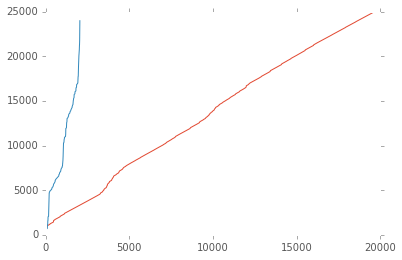

In [136]:
yf = sorted(u['id'] for u in users if u['gender'] == "F" and u['address'] != '' )
ym = sorted(u['id'] for u in users if u['gender'] == "M" and u['address'] != '' )
xf = range(len(yf))
xm = range(len(ym))
plt.plot(xf, yf)
plt.plot(xm, ym)

In [127]:
usmaller2 = [u for u in users if u['id'] < 24947]
ugreater2 = [u for u in users if u['id'] >= 80000]
print len(usmaller2), len(ugreater2), len(usmaller2) + len(ugreater2), len(users)
print min( u['id'] for u in users if u['id'] in trxn_users)

24946 58928 83874 83874
84034


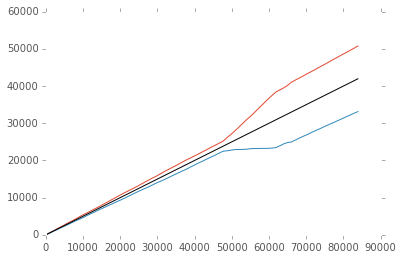

In [150]:
users = sorted(users, key=lambda u: u['id'])
gndr = [ u['gender'] == "F" for u in users]
x = np.array(range(len(gndr)))
plt.plot(x, np.cumsum(gndr))
plt.plot(x, np.cumsum( [not g for g in gndr]))
plt.plot(x, x/2, color="black")

In [37]:
uniqueAdr = []

for a, us in users_uniqueAdr.items():
    snnames = set(subnets_d[s][u'name'] if subnets_d.has_key(s) else str(s) 
                  for s in set(u[u'subnetwork_id'] for u in us))
    uniqueAdr.append( {u'address': a,
                      u'numUsers': len(us),
                      u'numMales': sum(u['gender'] == "M" for u in us),
                      u'numFemales': sum(u['gender'] == "F" for u in us),
                      u'subnetworks': snnames})
    
uniqueAdr_df = pd.DataFrame(uniqueAdr)
uniqueAdr_df[['address', 'numFemales',
              'numMales', 'numUsers']].head()

,address,numFemales,numMales,numUsers
0,bonne-espérance 28; 1006,1,0,1
1,37 route cantonnale; 1025,1,0,1
2,avenue de la dôle 4; 1005,1,0,1
3,abbesses 21; 2012,1,0,1
4,chemin de ponfilet 100; 1093,0,1,1


##Network Usage

In addition to how many transactions, users for each subnetwork, we can look at the number of stations and geographic subnetwork that a user uses.

In [125]:
trxn_users = set( t['user_id'] for t in trxns)
print "Fraction of users who have registered a transaction", (1.*len(trxn_users))/len(users)

Fraction of users who have registered a transaction 0.10673152586


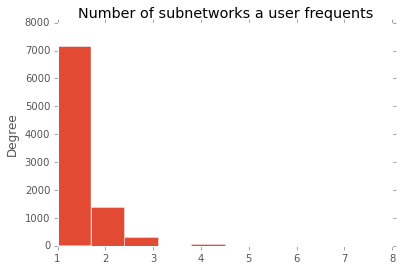

In [41]:
#Number of stations and subnetworks  a user frequents



user_trxn_stations = {u: {u'user_id': u,
                          u'stations': set(),
                          u'numTrxns': 0,
                          u'assigned_subnet': users_d[u][u'subnetwork_id']}
                      for u in trxn_users }

stn_subnet = { s[u'id']: s[u'subnetwork_id'] for s in stations}

for t in trxns:
    uid = t[u'user_id']
    user_trxn_stations[uid][u'stations'].add( t[u'station_id'])
    user_trxn_stations[uid][u'numTrxns'] += 1
    
for u in user_trxn_stations.keys():
    user = user_trxn_stations[u]
    user[u'numStations'] = len(user[u'stations'])
    user[u'stn_subnets'] = set( stn_subnet[s] for s in user[u'stations'] )
    user[u'numSubnets'] = len(user[u'stn_subnets'])

    
user_stations = pd.DataFrame(user_trxn_stations.values()).sort(['numStations'], 
                                                               ascending=False)
#user_stations[['user_id','assigned_subnet', 'numStations', 
 #              'numSubnets', 'numTrxns']].head()

user_stations['numSubnets'].plot(kind="hist", bins=10,
                                 title="Number of subnetworks a user frequents" )

#user_stations['numStations'].plot(kind='hist', logy=True, bins = 50,
#                               title="Number of stations a user frequents")

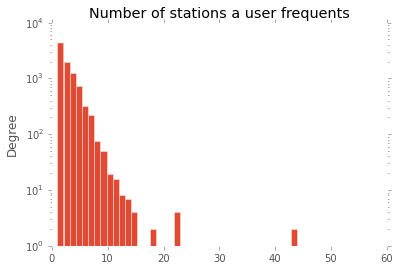

In [42]:
user_stations['numStations'].plot(kind='hist', logy=True, bins = 50,
                              title="Number of stations a user frequents")

#Appendix


In [76]:
print "Table characterizing subnetworks"
subnet_nums_df

Table characterizing subnetworks


,id,name,numStations,numTrxns_admin,numTrxns_geo,numUsers
name,,,,,,
La Cote,1,La Cote,13,0,71292,0
Bulle,3,Bulle,2,0,566,0
Les Lacs-Romont,4,Les Lacs-Romont,9,0,4964,0
Bâle,5,Bâle,0,0,0,0
Riviera,11,Riviera,5,0,11576,0
Morges,15,Morges,0,0,0,0
Chablais,6,Chablais,10,0,2377,3
Ouchy,16,Ouchy,0,0,0,3
Paradiso,17,Paradiso,0,0,0,3
